In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Load File
df_train = pd.read_csv('trafficVLCPyshark_train_s9.csv')  
df_test = pd.read_csv('trafficVLCPyshark_test_s9.csv')       

In [3]:
# Count occurrences of each unique class
class_counts_train = df_train["label"].value_counts()
class_counts_test = df_test["label"].value_counts()
print("Training Data")
print(class_counts_train)
print("----------------------")
print("Test Data")
print(class_counts_test)

Training Data
label
Roblox          15413
Video_Stream    13131
Web              7898
Teams            5438
Spotify          5192
Youtube          4615
Name: count, dtype: int64
----------------------
Test Data
label
Roblox          2188
Teams           1864
Video_Stream    1380
Web              683
Spotify          602
Youtube          560
Name: count, dtype: int64


In [4]:
#Delete columns
cols_to_drop = ['ip_src', 'src_port', 'ip_dst', 'dst_port', 'flow_id', 'window_number', 'total_packets', 'bytes', 'reverse_bytes', 'total_bytes', 'max_pkt_size', 'dt_intensity', 'avg_bytes', 'avg_dt_intensity', 'rms_pkt_size', 'iat_variance_ratio']
df_train.drop(columns=cols_to_drop, inplace=True)
df_test.drop(columns=cols_to_drop, inplace=True)

In [5]:
# Separate features with the objetive variable
X_train = df_train.drop('label', axis=1)
y_train = df_train['label']
X_test = df_test.drop('label', axis=1)
y_test = df_test['label']

In [6]:
# Encode labels using the same encoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [7]:
feature_names = X_train.columns 

In [8]:
# Splitting the data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [9]:
# XGBoost
#start_time = time.time()
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
#training_time = time.time() - start_time


In [10]:
#GridSearchCV, evaluation the training data in 5 folds.

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}


In [11]:
#best model
best_model = grid_search.best_estimator_

XGBoost_Training_Set:
  - Accuracy: 0.9902
  - F1 Score: 0.9901


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Roblox'),
  Text(0, 1, 'Spotify'),
  Text(0, 2, 'Teams'),
  Text(0, 3, 'Video_Stream'),
  Text(0, 4, 'Web'),
  Text(0, 5, 'Youtube')])

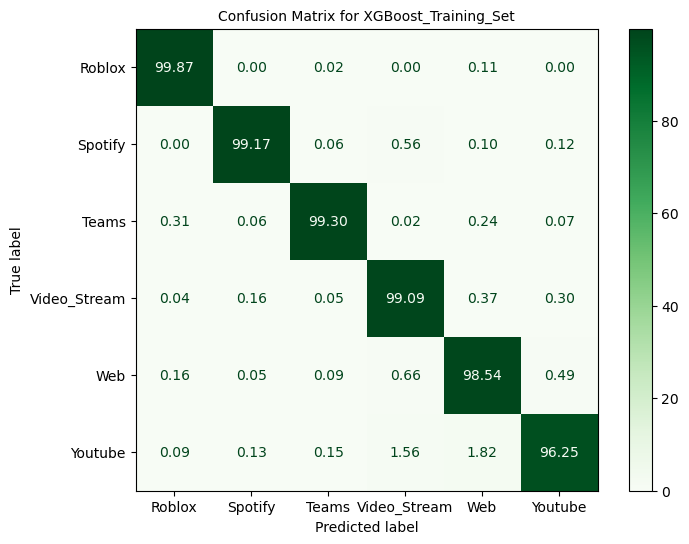

In [12]:
model_name = "XGBoost_Training_Set"
y_pred_train = best_model.predict(X_train_scaled)

cm_train = confusion_matrix(y_train, y_pred_train)
cm_train_percentage = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis] * 100
accuracy = accuracy_score(y_train, y_pred_train)
f1 = f1_score(y_train, y_pred_train, average='weighted')

print(f"{model_name}:")
#print(f"  - Training Time: {training_time:.4f}s")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - F1 Score: {f1:.4f}")

# Size
fig, ax = plt.subplots(figsize=(8, 6)) 

disp = ConfusionMatrixDisplay(confusion_matrix=cm_train_percentage, display_labels=label_encoder.classes_)
disp.plot(cmap='Greens', ax=ax, values_format=".2f")  

plt.title(f"Confusion Matrix for {model_name}", fontsize=10) 
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10)


In [13]:
report_xgb_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_, digits=4)
print("\nClasification Report Training - XGBoost")
print(report_xgb_train)


Clasification Report Training - XGBoost
              precision    recall  f1-score   support

      Roblox     0.9975    0.9987    0.9981     15413
     Spotify     0.9934    0.9917    0.9926      5192
       Teams     0.9950    0.9930    0.9940      5438
Video_Stream     0.9883    0.9909    0.9896     13131
         Web     0.9790    0.9854    0.9822      7898
     Youtube     0.9806    0.9625    0.9715      4615

    accuracy                         0.9902     51687
   macro avg     0.9890    0.9870    0.9880     51687
weighted avg     0.9901    0.9902    0.9901     51687



XGBoost_Test_Set:
  - Accuracy: 0.9133
  - F1 Score: 0.9149


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Roblox'),
  Text(0, 1, 'Spotify'),
  Text(0, 2, 'Teams'),
  Text(0, 3, 'Video_Stream'),
  Text(0, 4, 'Web'),
  Text(0, 5, 'Youtube')])

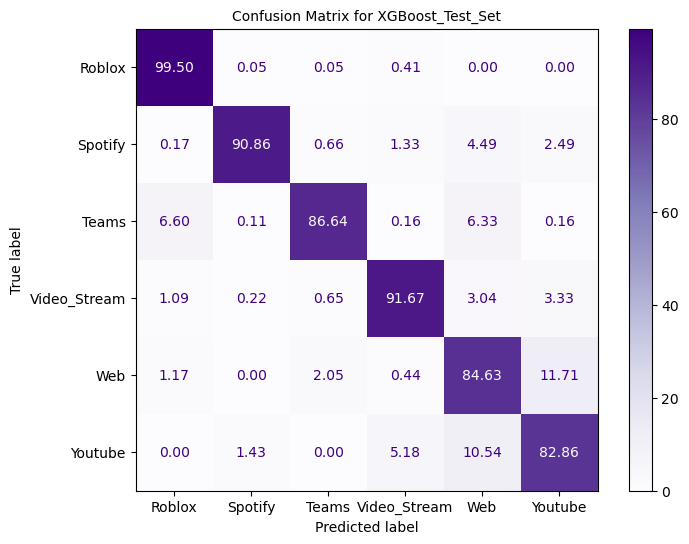

In [14]:
model_name = "XGBoost_Test_Set"
y_pred_test = best_model.predict(X_test_scaled)

cm_test = confusion_matrix(y_test, y_pred_test)
cm_test_percentage = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis] * 100
accuracy = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test, average='weighted')

print(f"{model_name}:")
#print(f"  - Training Time: {training_time:.4f}s")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - F1 Score: {f1:.4f}")

# Size
fig, ax = plt.subplots(figsize=(8, 6)) 

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test_percentage, display_labels=label_encoder.classes_)
disp.plot(cmap='Purples', ax=ax, values_format=".2f")  

plt.title(f"Confusion Matrix for {model_name}", fontsize=10) 
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10)

In [15]:
report_xgb_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_, digits=4)
print("\nClasification Report Test - XGBoost")
print(report_xgb_test)


Clasification Report Test - XGBoost
              precision    recall  f1-score   support

      Roblox     0.9367    0.9950    0.9650      2188
     Spotify     0.9750    0.9086    0.9407       602
       Teams     0.9830    0.8664    0.9210      1864
Video_Stream     0.9605    0.9167    0.9381      1380
         Web     0.7015    0.8463    0.7671       683
     Youtube     0.7632    0.8286    0.7945       560

    accuracy                         0.9133      7277
   macro avg     0.8866    0.8936    0.8877      7277
weighted avg     0.9208    0.9133    0.9149      7277



C:\Users\FrZ_M\AppData\Local\Temp\ipykernel_14252\1140940123.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")


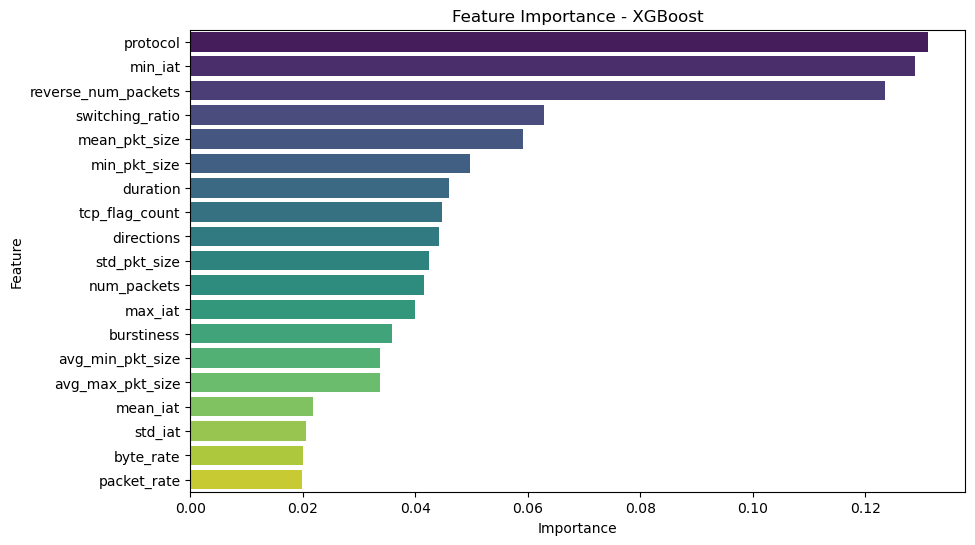

In [16]:
#feature Importances
importances = best_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - XGBoost')
plt.show()